In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np 
import pandas as pd
import seaborn as sns
import cv2
import os
import random
import matplotlib.pyplot as plt 
import pickle
from multiprocessing import Pool, Manager, cpu_count, Lock
import pickle
import keras 
from keras import models
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Activation,Dropout
import keras.losses
import time
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import tensorflow as tf

In [ ]:
X_train = pickle.load(open('/content/drive/MyDrive/Miczone/fingerprint/X_train.pkl','rb'))
Y_train = pickle.load(open('/content/drive/MyDrive/Miczone/fingerprint/Y_train.pkl','rb'))
X_test = pickle.load(open('/content/drive/MyDrive/Miczone/fingerprint/X_test.pkl','rb'))
Y_test = pickle.load(open('/content/drive/MyDrive/Miczone/fingerprint/Y_test.pkl','rb'))
X_val = pickle.load(open('/content/drive/MyDrive/Miczone/fingerprint/X_val.pkl','rb'))
Y_val = pickle.load(open('/content/drive/MyDrive/Miczone/fingerprint/Y_val.pkl','rb'))

In [ ]:
def scale_and_reshape_for_keras(X):
        # Calculate easier
        X = X.astype("float32") / 255.0

        # Dữ liệu input cho mô hình convolutional neural network là 1 tensor 4 chiều (N, W, H, D)
        # X = X.reshape(X.shape[0], X.shape[1], X.shape[2] , 1)
        X = np.stack((X,)*3, axis=-1) 

        return X

In [ ]:
X_train = scale_and_reshape_for_keras(X_train)
X_val = scale_and_reshape_for_keras(X_val)
X_test = scale_and_reshape_for_keras(X_test)

In [ ]:
Y_train = keras.utils.np_utils.to_categorical(Y_train)
Y_val = keras.utils.np_utils.to_categorical(Y_val)

In [ ]:
baseModel = tf.keras.applications.Xception(include_top=False, weights='imagenet', input_shape=(X_train.shape[1:]))

83697664/83683744 [==============================] - 0s 0us/step


In [ ]:
#get 3conv HEAD
mdl = tf.keras.Model(baseModel.inputs,outputs = baseModel.layers[ 92].output )
mdl.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [ ]:
n_outputs = 7

In [ ]:
fcHead = mdl.output

# Flatten trước khi dùng FCs
fcHead = Flatten(name='flatten')(fcHead)
# # Thêm FC
fcHead = Dense(512, activation='relu')(fcHead)
fcHead = Dropout(0.3)(fcHead)
# Output layer với softmax activation
fcHead = Dense(n_outputs, activation='softmax')(fcHead)
model = tf.keras.Model(inputs=baseModel.input, outputs=fcHead)

In [ ]:
for layer in baseModel.layers:
    layer.trainable =True 

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer='adam',
              metrics=['accuracy'])

In [ ]:
 history = model.fit(X_train, Y_train, epochs=30, validation_data =(X_val,Y_val),batch_size=32,verbose = 1,use_multiprocessing=True)

In [ ]:
pred = model.predict(X_test)
pred_idx = np.argmax(pred, axis=1)

In [ ]:
print(classification_report(Y_test, pred_idx))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       695
           1       0.86      0.76      0.81       129
           2       0.95      0.97      0.96      3582
           3       0.75      0.78      0.76      1297
           4       0.77      0.79      0.78      1316
           5       0.72      0.58      0.64        76
           6       0.78      0.66      0.71       700

    accuracy                           0.87      7795
   macro avg       0.83      0.78      0.80      7795
weighted avg       0.87      0.87      0.87      7795



In [ ]:
cm = confusion_matrix(Y_test,pred_idx)

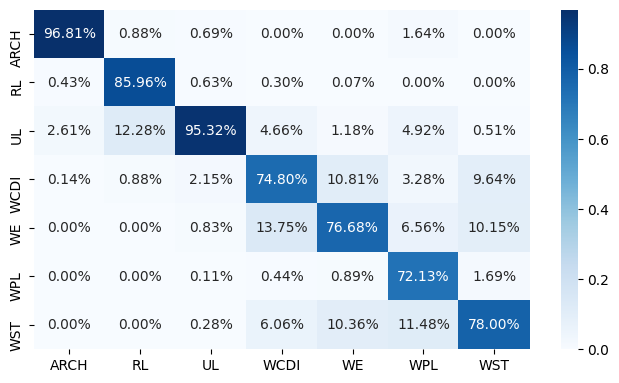

In [ ]:
df_cm = pd.DataFrame(cm, index=['ARCH', 'RL','UL','WCDI','WE',"WPL","WST"], columns=['ARCH', 'RL','UL','WCDI','WE',"WPL","WST"])
plt.figure(figsize = (8,4.5),dpi=100)
sns.heatmap(df_cm/np.sum(df_cm), cmap="Blues", annot=True,fmt='.2%')
plt.show()

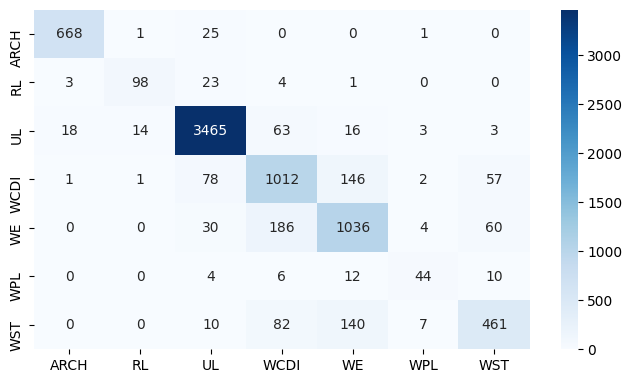

In [ ]:
df_cm = pd.DataFrame(cm, index=['ARCH', 'RL','UL','WCDI','WE',"WPL","WST"], columns=['ARCH', 'RL','UL','WCDI','WE',"WPL","WST"])
plt.figure(figsize = (8,4.5),dpi=100)
sns.heatmap(df_cm, cmap="Blues", annot=True,fmt='d')
plt.show()